# Chatbot Fundamentals 

## An interactive guide to writing bots in Python 

https://apps.worldwritable.com/tutorials/chatbot/

이 글은 서비스를 사용화하기 위한 튜토리얼은 아니지만 (아마 서비스를 위해서는 기존의 봇 플랫폼이나 프래임워크를 사용해야할 것이다.) 이 예제를 통해 conversational UI를 디자인하고 엔지니어링해 볼 좋은 기회를 가질 수 있다!

## The boundries of a bot 

당신이 conversational UI를 만들기 위해서는 다음 기본적 디자인 질문에 답해야 한다.

1. Domain knowledge: What does a user expect this bot to understand?

2. Personality: What tone or vocabulary does the bot employ?

### Domain knowledge 

순도 백퍼센트 AI는 존재하지 않지만, AI는 특정 사실에 기반한 답을 인간처럼 답할 수는 있다. 모든 봇들은 특정 주제에 한정되어 있다. 

Open domain vs Closed domain(대부분의 봇은 closed)

### Personality 

봇은 이해력의 부족으로 인해 진짜 인간보다 조금 덜떨어진 의인화를 해왔다. 하지만 이것은 어쩌면 창의적인 기회가 될 수도 있다. 진짜 인간 같은 의인화를 할 수 없다면 어떠한 컨셉을 정할 수 있을 것! <br>
<br>
__ELIZA__ 같은 경우 테라피 도메인에 맞게 테라피스트 같은 성격을 가지고 있다! 하지만 __Ecommerce bot__의 경우, 도메인 지식(제품, 사이즈, 주문 상태 등)만 잘 알면 되지 굳이 성격이 필요없기도 하다.

Often the dual axes of domain and personality align: in the program ELIZA, the domain was a therapy session, and the bot’s personality was that of a Rogerian therapist. Domain and personality don’t necessarily need to be tightly coupled, though—an ecommerce bot needs to know about products, sizing, and order status, but that domain doesn’t imply any particular kind of personality. A shopping bot could have the persona of a helpful person, a cheerful kitten, or have no personality at all.

## Meet "Brobot" 

아주 기본적인 수준의 챗봇 테크닉을 소개한다. 

In [1]:
# coding: utf-8
from __future__ import unicode_literals
import random
import re

In [2]:
from konlpy.utils import pprint
from konlpy.tag import Twitter

## 인사에 답하기! 

인사를 했을 때 답해주길 바랄 것이다. "greet the robot" 기능을 구현하기 위해 __simple keyword matching__ 테크닉을 사용할 수 있다. 

In [3]:
# Sentences we'll respond with if the user greeted us
GREETING_KEYWORDS = ("ㅎㅇ", "하이", "안녕", "안뇽", "하잉", 
                     "하이여","하이요","하이하이", "안녕하세요",)

GREETING_RESPONSES = ["ㅎㅇ", "하이~~","안뇽~", "안녕하세요:)"]

def check_for_greeting(sentence):
    """If any of the words in the user's input was a greeting, 
    return a greeting response"""
    sentence = re.sub("ㅎㅇ", "하이", sentence)
    words = re.sub("[^가-힣]", " ",  sentence).split()
    for word in words:
        if word.lower() in GREETING_KEYWORDS:
            return random.choice(GREETING_RESPONSES)

In [43]:
answer = check_for_greeting('ㅎㅇ!!! ㅋㅋㅋㅋ')
pprint(answer)

ㅎㅇ


이는 챗봇 내에서 가장 간단한 실행이다. 유저의 텍스트로부터 특정 단어가 포함되었는지를 체크하여 만약 있으면 저장해둔 답변으로부터 랜덤으로 뽑아서 실행한다.

###  Beyond keywords

파이썬으로 NLP를 하려면 두 개의 high-level 라이브러리를 필요로한다. 바로 TextBlob과 spaCy이다.spaCy는 사용하기 쉽고 빠르지만 메모리 집약적이고 통계적 NLP 전체를 커버하지 못할 수도 있다.
TextBlob은 NLTK의 wraping하는 api이다. 더 느리지만 이해력은 높다.

여기서는 TextBlob을 사용할 것이다. (저희는 __KonlPy__로 대체하겠습니다!)

Brobot의 메인 루프는 다음의 스텝을 따른다.

1. user's text에 초기 전처리를 가한다.(unsafe한 input을 체크하기도)

2. TextBlot을 사용하여 input을 파싱한다.

3. 유저의 발언으로부터 정보를 추출해내기 위한 루틴을 거친다.

4. 유저의 발언과 가장 매칭이 되는 답변을 구성한다.

5. 봇이 완전 이상한 대답을 할 수도 있으니 후처리를 가한다. (최악의 경우는 면하기 위해)

In [4]:
from konlpy.tag import Twitter

In [5]:
tagger = Twitter()

In [6]:
parsed=tagger.pos("너는 누구니?", stem=True, norm=True)

In [77]:
def respond(sentence):
    """유저의 발언을 파싱하여 가장 답변에 
    적절한 후보 단어들을 찾아낸다. """

    parsed = tagger.pos(sentence, stem=True, norm=True)
    
    # 한 문장 이상이 들어오면 루프를 돌며 적절한 단어들을 탐색한다.
    
    pronoun, noun, adjective, verb = find_candidate_parts_of_speech(parsed)

    # If we said something about the bot and used some kind of direct noun, construct the
    # sentence around that, discarding the other candidates
    resp = check_for_comment_about_bot(pronoun, noun, adjective)

    # If we just greeted the bot, we'll use a return greeting
    if not resp:
        resp = check_for_greeting(parsed)

    if not resp:
        # If we didn't override the final sentence, try to construct a new one:
        if not pronoun:
            resp = random.choice(NONE_RESPONSES)
        elif pronoun == 'I' and not verb:
            resp = random.choice(COMMENTS_ABOUT_SELF)
        else:
            resp = construct_response(pronoun, noun, verb)

    # If we got through all that with nothing, use a random response
    if not resp:
        resp = random.choice(NONE_RESPONSES)

    logger.info("Returning phrase '%s'", resp)
    # Check that we're not going to say anything obviously offensive
    filter_response(resp)

    return resp

In [11]:
def find_candidate_parts_of_speech(parsed):
    """파싱된 인풋을 받으면, 대명사와 명사, 형용사, 단어가 매치되는게 있는지 찾아서 튜플로 리턴한다."""
    pronoun = None
    noun = None
    adjective = None
    verb = None
    for sent in parsed:
        pronoun = find_pronoun(sent)
     #  noun = find_noun(sent)
     #   adjective = find_adjective(sent)
     #   verb = find_verb(sent)
   # logger.info("Pronoun=%s, noun=%s, adjective=%s, verb=%s", pronoun, noun, adjective, verb)
    return pronoun, noun, adjective, verb

각 find_* 함수는 TextBlob의 sentence.pos_tags 속성에 따라 speech 중 단어의 파트를 리턴한다.


In [9]:
def find_pronoun(sent):
    """Given a sentence, find a preferred pronoun to respond with. Returns None if no candidate
    pronoun is found in the input"""
    pronoun = None

    for w,t in sent:
        # Disambiguate pronouns
        if t == 'Noun' and w == '너':
            pronoun = '나'
        elif t == 'Noun' and w == '나':
            # If the user mentioned themselves, then they will definitely be the pronoun
            pronoun = '너'
    return pronoun

대명사를 찾아주는 함수의 예
유저가 'You'라고 하면 Brobot 입장에서는 'I'가 된다.

A more sophisticated approach would be to build a dependency tree. Dependency grammars describe the relationship among all clauses in a sentence, allowing you to discriminate between (say) the subject and object of a sentence. If your bot needs to know the difference between “dog bites man” and “man bites dog”, I recommend using the dependency parsing function of a library like spaCy.

### But enough about me, what do you think of me?

우리의 봇은 말하는 그 자체를 좋아한다. 이 특별한 루틴은 만약 유저가 bot에게 "you"라고 직접적 언급을 한 경우, 잠재적 답변을 만들어 낸다.

In [66]:
pprint(check_for_comment_about_bot('나', '사과', None))

네, 저 그거 잘 알아요 사과


In [62]:
def check_for_comment_about_bot(pronoun, noun, adjective):
    """Check if the user's input was about the bot itself, in which case try to fashion a response
    that feels right based on their input. Returns the new best sentence, or None."""
    resp = None
    if pronoun == '나' and (noun or adjective):
        if noun:
            resp = random.choice(SELF_VERBS_WITH_NOUN_LOWER).format(**{'noun': noun})
        else:
            resp = random.choice(SELF_VERBS_WITH_ADJECTIVE).format(**{'adjective': adjective})
    return resp

# Template for responses that include a direct noun which is indefinite/uncountable

SELF_VERBS_WITH_NOUN_LOWER = [
    "네, 저 그거 잘 알아요 {noun}",
    "항상 저한테 {noun} 물어보더라구요",
    "저도 {noun} 좋아해요",
    "{noun}이 뭐죠?",
    "아 {noun} 말씀이세요?",
    "저는 {noun} 전문가입니다!",
]

SELF_VERBS_WITH_ADJECTIVE = [
    "I'm personally building the {adjective} Economy",
    "I consider myself to be a {adjective}preneur",
]


실제 봇에서는 당신은 좀 더 정교한 <a href="http://jinja.pocoo.org/">templating engine</a>이 필요할 것이다.

### Constructing a realistic response 

일반적인 경우 유저의 텍스트로부터 파싱하여 단어를 알아낼 수 있지만 미처 처리하지 못한 단어들이 등장할 수도 있다. 
이 경우 프로그램은 이해하지 못한셈이다. 도메인 지식 밖의 일이라 예외를 만난 것이다.

하지만 여전히 당신은 성공적인 답변을 생성해내기 위해 유저의 인풋을 수정할 수 있다. 하지만 이는 이해해서 답했다기 보다는 로봇의 성격을 드러내는 것에 더 가깝다.

1. 만약 유저의 인풋으로부터 대명사를 받는다면 재활용한다.

2. 많은 경우, 유저의 동사를 안바꾸고 사용한다.

3. 만약 동사가 "to be"의 형태라면 이는 유저가 자기 자신에 대해 말하고 있는 것이다. (I am a good programmer), 이에 반대할 수도 있다?

4. 그렇지 않다면 그냥 유저의 오리지널 문장을 재조합하고 미사여구를 더한다.

In [95]:
pprint(tagger.pos("너 누구야", norm=True))

[(너, Noun), (누구, Noun), (야, Josa)]


In [36]:
def construct_response(pronoun, noun, verb, josa):
    """No special cases matched, so we're going to try to construct a full sentence that uses as much
    of the user's input as possible"""
    resp = []

    if pronoun:
        resp.append(pronoun)

    # We always respond in the present tense, and the pronoun will always either be a passthrough
    # from the user, or 'you' or 'I', in which case we might need to change the tense for some
    # irregular verbs.
    if josa:
        for josa_word in josa:
            if josa_word in ('이야', '다', '야', "거야"):  # This would be an excellent place to use lemmas!
                if pronoun.lower() == '너':
                    # The bot will always tell the person they aren't whatever they said they were
                    resp.append("")
                else:
                    resp.append(verb_word)
    if noun:
        resp.append(" " + noun)

    resp.append(random.choice(("ㅎㅎ", "ㅋㅋ")))

    return " ".join(resp)


### You've got to be kind 

마지막 루틴은 unsafe한 output을 방지하기 위한 필터로써 동작한다. 공격적 언어나 등을 필터링한다. 또한 문맥적으로 적절하지 않은 답변도 필터링한다. 

배드 봇을 방지하는 것은 이론적으로 불가능하지만 봇 크리에이터들은 최대한 윤리적 의무를 지키려 노력한다..!

In [37]:
def filter_response(resp):
    """Don't allow any words to match our filter list"""
    tokenized = resp.split(' ')
    for word in tokenized:
        if '@' in word or '#' in word or '!' in word:
            raise UnacceptableUtteranceException()
        for s in FILTER_WORDS:
            if word.lower().startswith(s):
                raise UnacceptableUtteranceException()

지금까지 Brobot의 여러 기능을 다뤘다. 하지만 전체 완성된 소스 코드들을 확인하길 바란다. https://github.com/lizadaly/brobot/ 



# 봇 프레임워크 API.ai  

참고 : http://hunkim.github.io/ml/ 

* User : How's the air quality in __Jeju__?
* Agent : __Jeju__ today's air quality is very good.

## Agent 

우리의 챗봇.!

## Intents (like function) 

유저의 발언 의도를 파악하는 함수(라고 생각하면 편할듯 합니다!) Agent는 여러 개의 Intents를 가질 수 있다. <br>
<br>
이 함수는 각각 parameter를 가질 수 있고 (이 parameter의 형식은 Entities일 것이다.), 또한 연속적 대화를 위한 global 변수 Context를 사용할 수도 있을 것.

- Parameter
- Context

## Entities (파라미터의 형태 like variable)

## Example

How's the air quality in __Jeju__? <br>
<br>
=> __String getWeather(location, time)__

즉, 요것이 봇 프레임워크의 역할!<br>
<br>
* String getWeather(location, time)
  - method name: intent
  - parameters: parameters
  - parameter types: entities
  - context: global variable

## API.ai architecture 

In [16]:
from IPython.display import Image

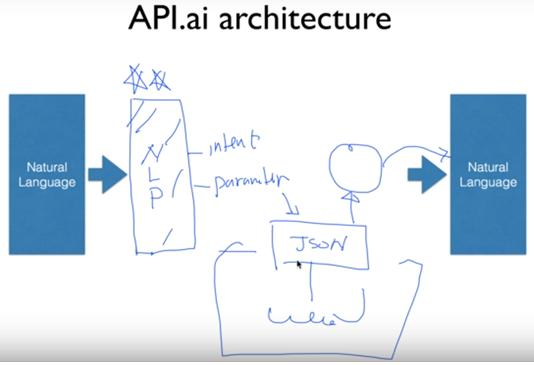

In [18]:
Image('./image/chatbottuto1.jpg')

In [13]:
# coding: utf-8
from __future__ import unicode_literals
import random
import re

from konlpy.utils import pprint
from konlpy.tag import Twitter



def check_for_greeting(sentence):
    
    # Sentences we'll respond with if the user greeted us
    GREETING_KEYWORDS = ("ㅎㅇ", "하이", "안녕", "안뇽", "하잉", 
                     "하이여","하이요","하이하이", "안녕하세요",)

    GREETING_RESPONSES = ["ㅎㅇ", "하이~~","안뇽~", "안녕하세요:)"]
    
    """If any of the words in the user's input was a greeting, 
    return a greeting response"""
    sentence = re.sub("ㅎㅇ", "하이", sentence)
    words = re.sub("[^가-힣]", " ",  sentence).split()
    for word in words:
        if word.lower() in GREETING_KEYWORDS:
            return random.choice(GREETING_RESPONSES)

        
        
def find_candidate_parts_of_speech(parsed):
    """파싱된 인풋을 받으면, 대명사와 명사, 형용사, 단어가 매치되는게 있는지 찾아서 튜플로 리턴한다."""
    pronoun = None
    noun = None
    who = None
    
    pronoun = find_pronoun(parsed)
    noun = find_noun(parsed)
    who = find_who(parsed)
    return pronoun, noun, who


def find_pronoun(sent):
    """Given a sentence, find a preferred pronoun to respond with. Returns None if no candidate
    pronoun is found in the input"""
    pronoun = None

    for w,t in sent:
        # Disambiguate pronouns
        if t == 'Noun' and (w == '너' or w =='넌'):
            pronoun = '나'
        elif t == 'Noun' and (w == '나' or w=='난'):
            # If the user mentioned themselves, then they will definitely be the pronoun
            pronoun = '너'
    return pronoun

def find_noun(sent):
    """Given a sentence, find the best candidate noun."""
    noun = None

    if not noun:
        for w, t in sent:
            if t == 'Noun' and w != '너' and w != '나':  # This is a noun
                noun = w
                break

    return noun

def find_who(sent):
    """Given a sentence, find the best candidate noun."""
    who = None

    for w, t in sent:
        if (t == 'Noun') and (w=='누구' or w =='뭐'):
            who = w
            break

    return who



def respond(sentence):
    """유저의 발언을 파싱하여 가장 답변에 
    적절한 후보 단어들을 찾아낸다. """
   
    NONE_RESPONSES = [
    "네..?",
    "잘 모르겠어요.",
    "흠, 그렇군요.",
    "아하!",
    "몰라요 ㅠㅠ",
    ]

    COMMENTS_ABOUT_SELF = [
        "저를 만든건 성동님이시죠.",
        "저는 딥사이어인 테스트봇입니다.",
        "저는 100점 만점에 {}점이죠".format(random.randint(100, 500)),
    ]

    tagger = Twitter()
    parsed = tagger.pos(sentence, stem=True, norm=True)
    
    # 한 문장 이상이 들어오면 루프를 돌며 적절한 단어들을 탐색한다.
    
    pronoun, noun, who = find_candidate_parts_of_speech(parsed)

    # If we said something about the bot and used some kind of direct noun, construct the
    # sentence around that, discarding the other candidates
    resp = check_for_greeting(sentence)
    # If we just greeted the bot, we'll use a return greeting

    if not resp:
        # If we didn't override the final sentence, try to construct a new one:
        if not pronoun:
            resp = random.choice(NONE_RESPONSES)
        elif pronoun == '나' and who:
            resp = random.choice(COMMENTS_ABOUT_SELF)
        else:
            resp = check_for_comment_about_bot(pronoun, noun)

    # If we got through all that with nothing, use a random response
    if not resp:
        resp = random.choice(NONE_RESPONSES)

    # Check that we're not going to say anything obviously offensive

    return resp

def check_for_comment_about_bot(pronoun, noun):
    """Check if the user's input was about the bot itself, in which case try to fashion a response
    that feels right based on their input. Returns the new best sentence, or None."""
    resp = None
    
    SELF_VERBS_WITH_NOUN_LOWER = [
        "네, 저 그거 잘 알아요 {noun}",
        "항상 저한테 {noun} 물어보더라구요",
        "저도 {noun} 좋아해요",
        "{noun}이 뭐죠?",
        "아 {noun} 말씀이세요?",
        "저는 {noun} 전문가입니다!",
    ]
    if pronoun == '나' and noun:
            resp = random.choice(SELF_VERBS_WITH_NOUN_LOWER).format(**{'noun': noun})

    return resp

    # Template for responses that include a direct noun which is indefinite/uncountable

In [14]:
pprint(parsed)

[(너, Noun),
 (는, Josa),
 (누구, Noun),
 (니, Josa),
 (?, Punctuation)]


In [15]:
pronoun, noun, who = find_candidate_parts_of_speech(parsed)

In [16]:
pprint(pronoun)
pprint(who)

나
누구
